<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/AIIA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

In [2]:
# Google Drive 마운트
drive.mount('/content/drive')

# GPU 사용 여부 확인
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device:", DEVICE)


Mounted at /content/drive
Using Device: cuda


In [3]:
!pip install gdown==4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [4]:
!gdown https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Downloading...
From: https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
To: /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
100% 2.00k/2.00k [00:00<00:00, 10.6MB/s]


In [7]:
!unzip /content/drive/MyDrive/Original_Food_10 -d "/content/drive/MyDrive/Unzipped_Food_8"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_101.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_102.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_103.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_104.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_105.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_106.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_107.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_108.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_109.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_11.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_110.jpg  
  inflating: /content/drive/MyDrive/Unzipped_Food_8/oysters/oysters_111.jpg  
  inflating: /content/drive/M

In [8]:
# 데이터 경로 설정
path = "/content/drive/MyDrive/Unzipped_Food_8"

In [9]:
# 학습 설정값
validation_split = 0.2
batch_size = 32
LR = 1e-3
model_type = "ResNet101_Custom_lr0.001_v4"
criterion = nn.CrossEntropyLoss()
shuffle_dataset = True
random_seed = 42
# Early Stopping 설정
num_epochs = 40
patience = 10  # 검증 손실이 개선되지 않아도 몇 epoch까지 기다릴지
best_loss = float("inf")  # 최소 Validation Loss 저장
counter = 0  # Early Stopping 체크용 카운터


In [10]:
# 커스텀 Sharpness 조정 클래스
class AdjustSharpnessCustom:
    def __init__(self, sharpness_factor):
        self.sharpness_factor = sharpness_factor

    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(self.sharpness_factor)

In [11]:
# 데이터 전처리 및 증강
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 수평 플립
        transforms.CenterCrop(256),  # 중앙 크롭
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 정규화
    ]),
    "test": transforms.Compose([
        transforms.Resize((256, 256)),  # 더 큰 크기로 리사이즈
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 정규화
    ])
}


In [12]:
# 데이터셋 불러오기
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])
class_names = image_datasets.classes  # 클래스 목록 가져오기

In [13]:



# 데이터셋 분할
dataset_size = len(image_datasets)
test_split = 0.1
val_split = 0.2
print(dataset_size)

test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])
print(test_size, val_size, train_size)

10000
1000 2000 7000


In [14]:
# 검증 & 테스트 데이터에는 augmentation을 적용하지 않도록 transform 수정
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로딩 확인
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)

Train Batch Labels: tensor([3, 2, 0, 2, 8, 5, 7, 6, 5, 8, 0, 0, 1, 9, 1, 2, 1, 9, 0, 3, 7, 4, 0, 2,
        8, 4, 8, 6, 1, 9, 9, 0])


샘플 라벨 5개 출력:
tensor([5, 3, 1, 1, 8])


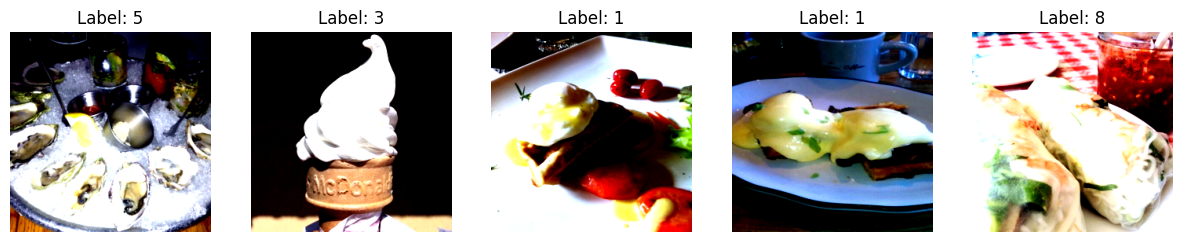

샘플 라벨 5개 출력:
tensor([7, 4, 0, 8, 7])


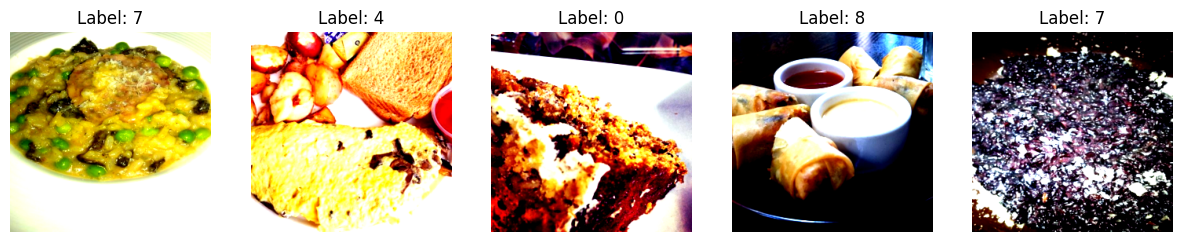

In [15]:
# 데이터 로더에서 샘플 배치 확인
def check_labels(dataloader, num_samples=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    print(f"샘플 라벨 {num_samples}개 출력:")
    print(labels[:num_samples])

    # 시각화 (이미지 & 라벨 확인)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis("off")

    plt.show()

# 학습 데이터 로더에서 확인
check_labels(train_loader)

# 검증 데이터 로더에서도 확인 가능
check_labels(validation_loader)


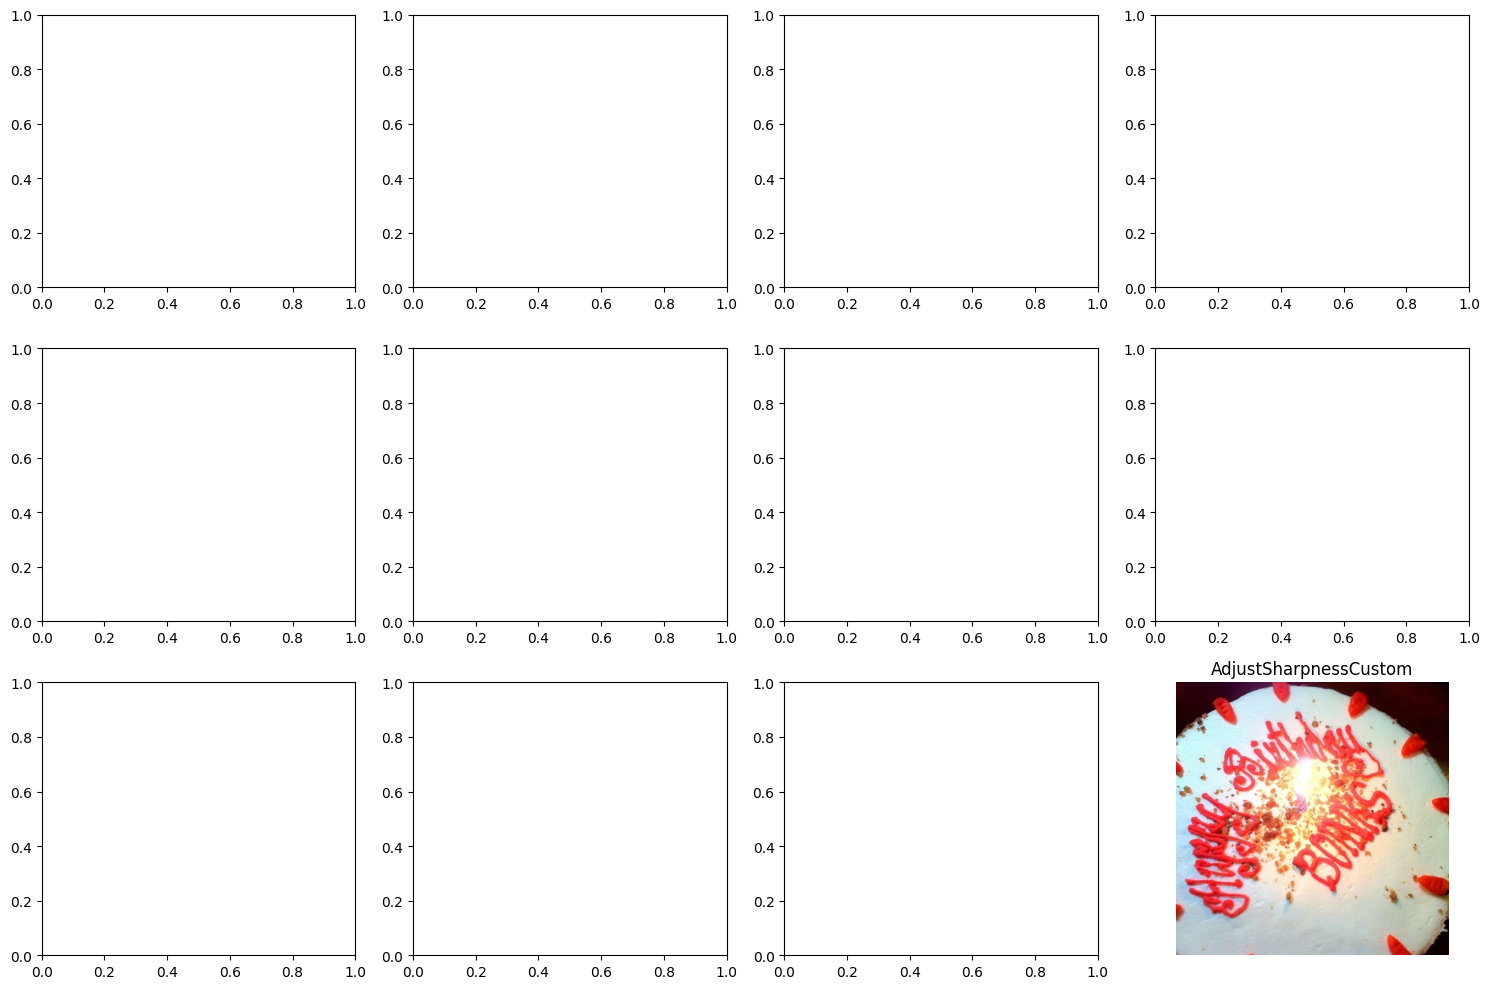

In [16]:

# 샘플 이미지 불러오기
sample_img_path, _ = image_datasets.samples[0]  # 데이터셋에서 첫 번째 이미지
sample_img = Image.open(sample_img_path).convert("RGB")  # RGB 변환

# 시드 고정 (랜덤 변환 결과 일관성 유지)
torch.manual_seed(42)

# Augmentation 과정별 변환 리스트 (랜덤 값 고정)
transform_steps = [
    ("Original", transforms.ToTensor()),
    ("RandomResizedCrop", transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.ToTensor()
    ])),
    ("RandomHorizontalFlip", transforms.Compose([
        transforms.RandomHorizontalFlip(1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("RandomRotation", transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor()
    ])),
    ("RandomAffine", transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.ToTensor()
    ])),
    ("ColorJitter", transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.08),
        transforms.ToTensor()
    ])),
    ("RandomPerspective", transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("GaussianBlur", transforms.Compose([
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=1.0),
        transforms.ToTensor()
    ])),
    ("RandomErasing", transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3))
    ])),
    ("CenterCrop", transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])),
    ("AdjustSharpnessCustom", transforms.Compose([
        AdjustSharpnessCustom(1.5),
        transforms.ToTensor()
    ]))
]

# 이미지 출력 함수
def show_image(tensor, title):
    img = tensor.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # 0~1 범위로 정규화
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# 변환된 이미지 출력
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# 각 변환을 순차적으로 적용
for ax, (name, transform) in zip(axes.flat, transform_steps):
    transformed_img = transform(sample_img)  # 변환 적용
    show_image(transformed_img, name)

plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride, padding=1, bias=False):
    return nn.Conv2d(in_planes, out_planes,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias
    )

def conv1x1(in_planes, out_planes, stride, padding=0, bias=False):
    return nn.Conv2d(in_planes, out_planes,
        kernel_size=1,
        stride=stride,
        padding=padding,
        bias=bias
    )

# 1. SE Block 추가
class SEBlock(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_planes, in_planes // reduction)
        self.fc2 = nn.Linear(in_planes // reduction, in_planes)

    def forward(self, x):
        b, c, _, _ = x.size()
        out = F.adaptive_avg_pool2d(x, 1).view(b, c)  # Squeeze
        out = F.relu(self.fc1(out))  # Excitation
        out = torch.sigmoid(self.fc2(out)).view(b, c, 1, 1)
        return x * out  # Channel-wise scaling

# 2. 기존 BottleNeck에 SEBlock 적용
class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.3, reduction=16):
        super(BottleNeck, self).__init__()

        self.conv1 = conv1x1(in_planes, out_planes, stride)
        self.conv2 = conv3x3(out_planes, out_planes, 1, 1)
        self.conv3 = conv1x1(out_planes, out_planes * self.mul, 1)

        self.bn1 = nn.BatchNorm2d(out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.bn3 = nn.BatchNorm2d(out_planes * self.mul)

        self.dropout = nn.Dropout(p=dropout_rate)
        self.se = SEBlock(out_planes * self.mul, reduction)  # ⬅️ SEBlock 추가

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes * self.mul:
            self.shortcut = nn.Sequential(
                conv1x1(in_planes, out_planes * self.mul, stride),
                nn.BatchNorm2d(out_planes * self.mul)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)  # ⬅️ SE 모듈 적용
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# 3. ResNet 클래스는 그대로 유지
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        _layers = []
        outputs, strides = [64, 128, 256, 512], [1, 2, 2, 2]
        for i in range(4):
            _layers.append(self._make_layer(block, outputs[i], num_blocks[i], stride=strides[i]))
        self.layers = nn.Sequential(*_layers)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def _make_layer(self, block, out_planes, num_block, stride):
        layers = [block(self.in_planes, out_planes, stride)]
        self.in_planes = block.mul * out_planes
        for i in range(num_block - 1):
            layers.append(block(self.in_planes, out_planes, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.maxpool(out)
        out = self.layers(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


In [18]:
# CNN Feature Map 시각화 추가
def visualize_feature_maps(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가
    with torch.no_grad():
        for name, layer in model.named_children():
            if isinstance(layer, torch.nn.Conv2d):
                feature_map = layer(image)
                feature_map = feature_map.cpu().squeeze(0)
                num_features = feature_map.shape[0]
                fig, axes = plt.subplots(1, min(num_features, 6), figsize=(15, 5))
                for i in range(min(num_features, 6)):
                    axes[i].imshow(feature_map[i], cmap='viridis')
                    axes[i].axis('off')
                plt.show()
                break

# 입력 이미지 상위 5개 예측 결과 출력 함수 추가
def predict_top5(model, image, class_names, device):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)

    top5_probs = top5_probs.cpu().numpy().flatten()
    top5_indices = top5_indices.cpu().numpy().flatten()

    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{class_names[top5_indices[i]]}: {top5_probs[i] * 100:.2f}%")

In [19]:
def ResNet18():
    return ResNet(BottleNeck, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [20]:
model = ResNet101()
model = model.to(DEVICE)

In [21]:
model

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): BottleNeck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (se): SEBlock(
          (fc1): Linear(in_features=256, out_features=16, bia

In [22]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [23]:
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(
    optimizer,
    max_lr=LR,  # 최대 학습률
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,  # num_epochs 변수 사용
    pct_start=0.3,  # 첫 30%는 학습률 증가, 이후 감소
    div_factor=25,  # 초기 학습률 = max_lr/div_factor
    final_div_factor=1e4,  # 최종 학습률 = max_lr/final_div_factor
    anneal_strategy='cos'  # 코사인 방식으로 학습률 조정
)

In [24]:
from collections import Counter

labels = [label for _, label in image_datasets.samples]
class_counts = Counter(labels)
print(class_counts)  # 클래스별 데이터 개수 출력


Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


In [25]:
# 모델 저장 & 로드 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f" 모델 저장 완료: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    print(f"🔹 Model loaded from {path} to {device}")
    return model

# 추가: 누락된 validate_model 함수
from tqdm import tqdm

def validate_model(model, validation_loader, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    val_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=False)  # ✅ tqdm 추가

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:  # ✅ tqdm 적용된 데이터 로더 사용
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_loader_tqdm.set_postfix(loss=loss.item())  # ✅ tqdm 진행 상태 업데이트

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total
    return avg_val_loss, val_acc


In [26]:
def plot_training(history):
    # Validation metrics are calculated every epoch
    # So, we use the same x-axis for validation and training data
    val_epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history["train_loss"]) + 1), history["train_loss"], label="Train Loss", marker="o")
    plt.plot(val_epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history["train_acc"]) + 1), history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(val_epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [27]:

# 학습 기록 저장용
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# 체크포인트 저장 경로
checkpoint_path = "checkpoint.pth"

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()  # 배치마다 학습률 업데이트

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 학습 기록 저장
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    # Validation 수행 (매 epoch마다 실행)
    model.eval()
    avg_val_loss, val_acc = validate_model(model, validation_loader, DEVICE)

    print(f"🔹 Validation at Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # Early Stopping 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0  # 개선되었으므로 counter 초기화
        # 체크포인트 저장
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch+1}, loss: {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"⚠️ Early Stopping Counter: {counter}/{patience}")


    # patience 이상으로 개선이 없으면 학습 중단
    if counter >= patience:
        print("⛔ Early stopping triggered! Training stopped.")
        break

# 체크포인트에서 최적 모델 불러오기
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"✅ Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")

# 학습 종료 후 최종 Validation 수행
final_val_loss, final_val_acc = validate_model(model, validation_loader, DEVICE)
print(f"🔹 Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")


Epoch 1/40: 100%|██████████| 219/219 [03:29<00:00,  1.05it/s, loss=2.5]


Epoch 1/40, Train Loss: 2.3475, Train Acc: 0.1241


🔹 Validation at Epoch 1: Val Loss: 4.3312, Val Acc: 0.0955
✅ Checkpoint saved at epoch 1, loss: 4.3312


Epoch 2/40: 100%|██████████| 219/219 [03:31<00:00,  1.04it/s, loss=2.38]


Epoch 2/40, Train Loss: 2.2225, Train Acc: 0.1870


🔹 Validation at Epoch 2: Val Loss: 3.8948, Val Acc: 0.1835
✅ Checkpoint saved at epoch 2, loss: 3.8948


Epoch 3/40: 100%|██████████| 219/219 [03:29<00:00,  1.05it/s, loss=2.18]


Epoch 3/40, Train Loss: 2.1104, Train Acc: 0.2560


🔹 Validation at Epoch 3: Val Loss: 4.1959, Val Acc: 0.1895
⚠️ Early Stopping Counter: 1/10


Epoch 4/40: 100%|██████████| 219/219 [03:27<00:00,  1.05it/s, loss=1.86]


Epoch 4/40, Train Loss: 1.9527, Train Acc: 0.3186


🔹 Validation at Epoch 4: Val Loss: 4.6795, Val Acc: 0.1850
⚠️ Early Stopping Counter: 2/10


Epoch 5/40: 100%|██████████| 219/219 [03:27<00:00,  1.06it/s, loss=1.51]


Epoch 5/40, Train Loss: 1.8267, Train Acc: 0.3646


🔹 Validation at Epoch 5: Val Loss: 1.9900, Val Acc: 0.3490
✅ Checkpoint saved at epoch 5, loss: 1.9900


Epoch 6/40: 100%|██████████| 219/219 [03:27<00:00,  1.05it/s, loss=1.66]


Epoch 6/40, Train Loss: 1.6972, Train Acc: 0.4199


🔹 Validation at Epoch 6: Val Loss: 3.5409, Val Acc: 0.1795
⚠️ Early Stopping Counter: 1/10


Epoch 7/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=1.92]


Epoch 7/40, Train Loss: 1.6215, Train Acc: 0.4436


🔹 Validation at Epoch 7: Val Loss: 1.8345, Val Acc: 0.4260
✅ Checkpoint saved at epoch 7, loss: 1.8345


Epoch 8/40: 100%|██████████| 219/219 [03:27<00:00,  1.05it/s, loss=1.82]


Epoch 8/40, Train Loss: 1.5604, Train Acc: 0.4703


🔹 Validation at Epoch 8: Val Loss: 1.9802, Val Acc: 0.4280
⚠️ Early Stopping Counter: 1/10


Epoch 9/40: 100%|██████████| 219/219 [03:27<00:00,  1.06it/s, loss=1.41]


Epoch 9/40, Train Loss: 1.5272, Train Acc: 0.4861


🔹 Validation at Epoch 9: Val Loss: 1.5751, Val Acc: 0.4505
✅ Checkpoint saved at epoch 9, loss: 1.5751


Epoch 10/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=1.05]


Epoch 10/40, Train Loss: 1.4373, Train Acc: 0.5240


🔹 Validation at Epoch 10: Val Loss: 1.8009, Val Acc: 0.4725
⚠️ Early Stopping Counter: 1/10


Epoch 11/40: 100%|██████████| 219/219 [03:25<00:00,  1.06it/s, loss=1.54]


Epoch 11/40, Train Loss: 1.3605, Train Acc: 0.5403


🔹 Validation at Epoch 11: Val Loss: 1.5672, Val Acc: 0.4920
✅ Checkpoint saved at epoch 11, loss: 1.5672


Epoch 12/40: 100%|██████████| 219/219 [03:27<00:00,  1.06it/s, loss=1.43]


Epoch 12/40, Train Loss: 1.2840, Train Acc: 0.5670


🔹 Validation at Epoch 12: Val Loss: 1.6132, Val Acc: 0.4995
⚠️ Early Stopping Counter: 1/10


Epoch 13/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=1.11]


Epoch 13/40, Train Loss: 1.2143, Train Acc: 0.5966


🔹 Validation at Epoch 13: Val Loss: 1.4920, Val Acc: 0.5145
✅ Checkpoint saved at epoch 13, loss: 1.4920


Epoch 14/40: 100%|██████████| 219/219 [03:28<00:00,  1.05it/s, loss=1.44]


Epoch 14/40, Train Loss: 1.1210, Train Acc: 0.6266


🔹 Validation at Epoch 14: Val Loss: 1.4743, Val Acc: 0.5320
✅ Checkpoint saved at epoch 14, loss: 1.4743


Epoch 15/40: 100%|██████████| 219/219 [03:29<00:00,  1.05it/s, loss=1.31]


Epoch 15/40, Train Loss: 1.0541, Train Acc: 0.6467


🔹 Validation at Epoch 15: Val Loss: 1.3678, Val Acc: 0.5650
✅ Checkpoint saved at epoch 15, loss: 1.3678


Epoch 16/40: 100%|██████████| 219/219 [03:27<00:00,  1.06it/s, loss=1.08]


Epoch 16/40, Train Loss: 0.9629, Train Acc: 0.6829


🔹 Validation at Epoch 16: Val Loss: 1.2460, Val Acc: 0.5825
✅ Checkpoint saved at epoch 16, loss: 1.2460


Epoch 17/40: 100%|██████████| 219/219 [03:25<00:00,  1.07it/s, loss=0.734]


Epoch 17/40, Train Loss: 0.9191, Train Acc: 0.6901


🔹 Validation at Epoch 17: Val Loss: 1.4324, Val Acc: 0.5570
⚠️ Early Stopping Counter: 1/10


Epoch 18/40: 100%|██████████| 219/219 [03:25<00:00,  1.06it/s, loss=0.699]


Epoch 18/40, Train Loss: 0.8263, Train Acc: 0.7254


🔹 Validation at Epoch 18: Val Loss: 1.1569, Val Acc: 0.6320
✅ Checkpoint saved at epoch 18, loss: 1.1569


Epoch 19/40: 100%|██████████| 219/219 [03:27<00:00,  1.06it/s, loss=0.901]


Epoch 19/40, Train Loss: 0.7571, Train Acc: 0.7519


🔹 Validation at Epoch 19: Val Loss: 1.2333, Val Acc: 0.6075
⚠️ Early Stopping Counter: 1/10


Epoch 20/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.723]


Epoch 20/40, Train Loss: 0.6801, Train Acc: 0.7686


🔹 Validation at Epoch 20: Val Loss: 1.1628, Val Acc: 0.6615
⚠️ Early Stopping Counter: 2/10


Epoch 21/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.632]


Epoch 21/40, Train Loss: 0.5962, Train Acc: 0.7953


🔹 Validation at Epoch 21: Val Loss: 1.2429, Val Acc: 0.6285
⚠️ Early Stopping Counter: 3/10


Epoch 22/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=1.27]


Epoch 22/40, Train Loss: 0.5241, Train Acc: 0.8221


🔹 Validation at Epoch 22: Val Loss: 1.1387, Val Acc: 0.6660
✅ Checkpoint saved at epoch 22, loss: 1.1387


Epoch 23/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.255]


Epoch 23/40, Train Loss: 0.4296, Train Acc: 0.8500


🔹 Validation at Epoch 23: Val Loss: 1.2499, Val Acc: 0.6620
⚠️ Early Stopping Counter: 1/10


Epoch 24/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.408]


Epoch 24/40, Train Loss: 0.3892, Train Acc: 0.8723


🔹 Validation at Epoch 24: Val Loss: 1.2294, Val Acc: 0.6620
⚠️ Early Stopping Counter: 2/10


Epoch 25/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.425]


Epoch 25/40, Train Loss: 0.3127, Train Acc: 0.8947


🔹 Validation at Epoch 25: Val Loss: 1.1940, Val Acc: 0.6800
⚠️ Early Stopping Counter: 3/10


Epoch 26/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.119]


Epoch 26/40, Train Loss: 0.2386, Train Acc: 0.9213


🔹 Validation at Epoch 26: Val Loss: 1.4799, Val Acc: 0.6690
⚠️ Early Stopping Counter: 4/10


Epoch 27/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.135]


Epoch 27/40, Train Loss: 0.1897, Train Acc: 0.9346


🔹 Validation at Epoch 27: Val Loss: 1.4423, Val Acc: 0.6850
⚠️ Early Stopping Counter: 5/10


Epoch 28/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.169]


Epoch 28/40, Train Loss: 0.1608, Train Acc: 0.9454


🔹 Validation at Epoch 28: Val Loss: 1.4339, Val Acc: 0.6940
⚠️ Early Stopping Counter: 6/10


Epoch 29/40: 100%|██████████| 219/219 [03:26<00:00,  1.06it/s, loss=0.143]


Epoch 29/40, Train Loss: 0.1116, Train Acc: 0.9609


🔹 Validation at Epoch 29: Val Loss: 1.4329, Val Acc: 0.7060
⚠️ Early Stopping Counter: 7/10


Epoch 30/40: 100%|██████████| 219/219 [03:25<00:00,  1.06it/s, loss=0.191]


Epoch 30/40, Train Loss: 0.0804, Train Acc: 0.9754


🔹 Validation at Epoch 30: Val Loss: 1.5887, Val Acc: 0.7085
⚠️ Early Stopping Counter: 8/10


Epoch 31/40: 100%|██████████| 219/219 [03:25<00:00,  1.07it/s, loss=0.182]


Epoch 31/40, Train Loss: 0.0631, Train Acc: 0.9801


🔹 Validation at Epoch 31: Val Loss: 1.5321, Val Acc: 0.7105
⚠️ Early Stopping Counter: 9/10


Epoch 32/40: 100%|██████████| 219/219 [03:25<00:00,  1.07it/s, loss=0.21]


Epoch 32/40, Train Loss: 0.0375, Train Acc: 0.9881


🔹 Validation at Epoch 32: Val Loss: 1.6362, Val Acc: 0.7035
⚠️ Early Stopping Counter: 10/10
⛔ Early stopping triggered! Training stopped.
✅ Model restored from checkpoint at epoch 22, loss: 1.1387


🔹 Final Validation Loss: 1.1387, Final Validation Accuracy: 0.6660


In [28]:

# 테스트 데이터 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    return avg_test_loss, test_acc

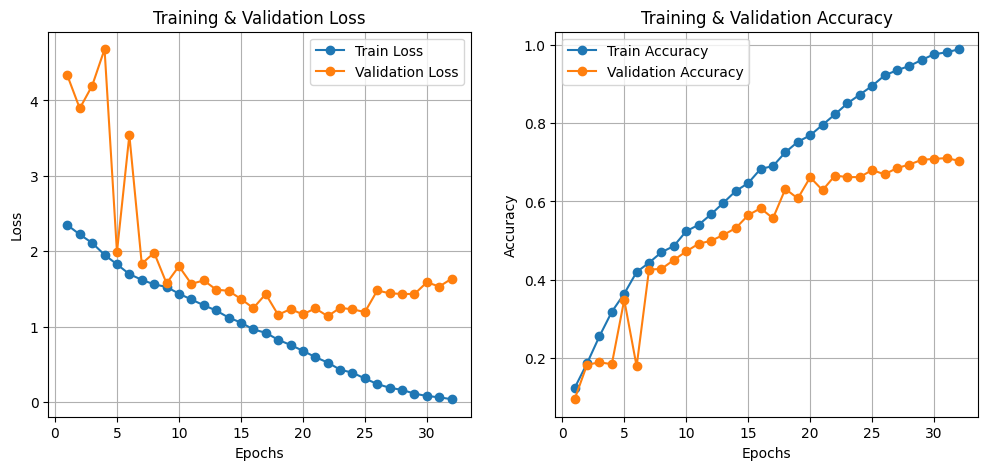

평균 손실: 1.0742
정확도: 68.00%


In [29]:
# 학습 과정 그래프 그리기
plot_training(history)

# 테스트 데이터 평가 실행
avg_test_loss, test_acc = test_model(model, test_loader, DEVICE)
print(f"평균 손실: {avg_test_loss:.4f}")
print(f"정확도: {test_acc * 100:.2f}%")

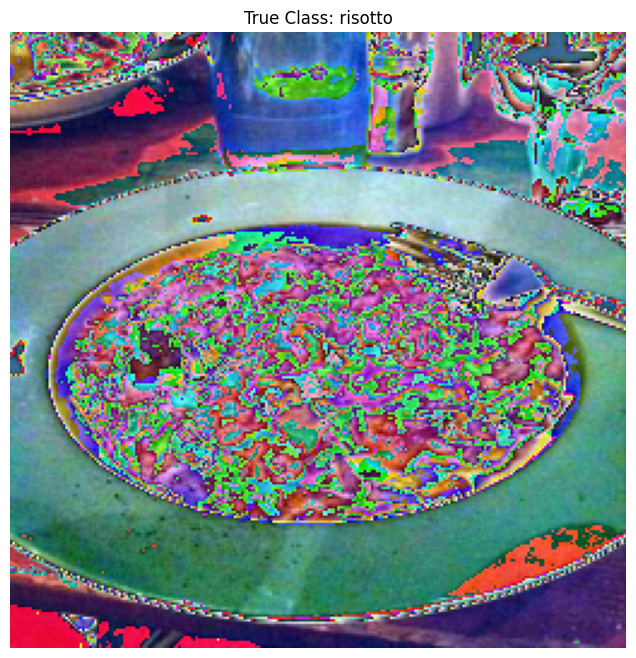

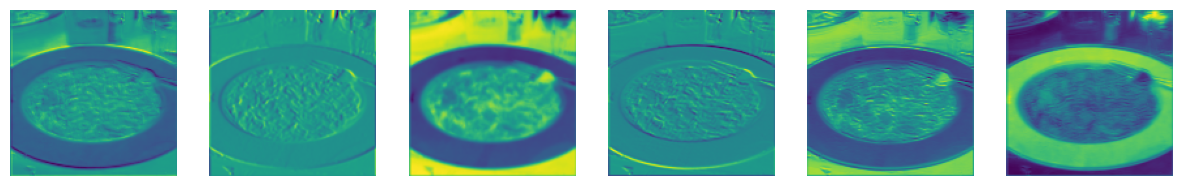

Top 5 Predictions:
risotto: 97.52%
paella: 1.39%
omelette: 1.06%
carrot_cake: 0.02%
french_toast: 0.01%


In [30]:
# 샘플 이미지에 대한 예측 및 시각화 예시 코드
def visualize_sample_predictions():
    # 테스트 세트에서 몇 개의 샘플 가져오기
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # 샘플 이미지 선택
    sample_idx = 0
    sample_image = images[sample_idx]
    sample_label = labels[sample_idx]

    # 원본 이미지 표시
    plt.figure(figsize=(8, 8))
    plt.imshow(transforms.ToPILImage()(sample_image))
    plt.title(f"True Class: {class_names[sample_label]}")
    plt.axis('off')
    plt.show()

    # 특성 맵 시각화
    visualize_feature_maps(model, sample_image, DEVICE)

    # 상위 5개 예측 결과 출력
    predict_top5(model, sample_image, class_names, DEVICE)

# 샘플 이미지에 대한 시각화 실행
visualize_sample_predictions()